## Compare HermiteKAN's ability in function interpolation with MLP (Multi-variable)

In [93]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from HermiteKANLayer import HermiteKANLayer

In [94]:
# Define the fractal-like 2D function
def fractal_function(x, y):
    z = np.sin(10 * np.pi * x) * np.cos(10 * np.pi * y) + np.sin(np.pi * (x**2 + y**2))
    z += np.abs(x - y) + (np.sin(5 * x * y) / (0.1 + np.abs(x + y)))
    z *= np.exp(-0.1 * (x**2 + y**2))
    
    # Add noise to z
    noise = np.random.normal(0, 0.1, z.shape)
    z += noise
    
    return z

In [95]:
# Define MLP and HermiteKAN
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )
    
    def forward(self, x):
        return self.layers(x)
        
# Define the HermiteKAN model
class HermiteKAN(nn.Module):
    def __init__(self):
        super(HermiteKAN, self).__init__()
        # Define each Hermite polynomial layer
        self.hermitekan0 = HermiteKANLayer(2, 4, 1)
        self.hermitekan1 = HermiteKANLayer(4, 8, 1)
        self.hermitekan2 = HermiteKANLayer(8, 16, 2)
        self.hermitekan3 = HermiteKANLayer(16, 16, 3)
        self.hermitekan4 = HermiteKANLayer(16, 16, 4)
        self.hermitekan5 = HermiteKANLayer(16, 8, 3)
        self.hermitekan6 = HermiteKANLayer(8, 4, 2)
        self.hermitekan7 = HermiteKANLayer(4, 1, 1)  # Final layer outputs to 1 dimension

        # Regularization layers
        self.dropout = nn.Dropout(0.15)  # Dropout layer with p=0.25
        self.norm1 = nn.BatchNorm1d(8)  # Batch normalization for output with 8 dimensions
        self.norm2 = nn.BatchNorm1d(16)  # Batch normalization for output with 16 dimensions

    def forward(self, x):
        x = self.hermitekan0(x)
        x = self.dropout(x)  # Apply dropout after the first layer
        x = self.hermitekan1(x)
        x = self.norm1(x)  # Apply batch normalization after the second layer
        x = self.hermitekan2(x)
        x = self.norm2(x)  # Apply batch normalization after the third layer
        x = self.hermitekan3(x)
        x = self.dropout(x)  # Apply dropout after the fourth layer
        x = self.hermitekan4(x)
        x = self.norm2(x)  # Apply batch normalization after the fifth layer
        x = self.hermitekan5(x)
        x = self.norm1(x)  # Apply batch normalization after the sixth layer
        x = self.hermitekan6(x)
        x = self.dropout(x)  # Apply dropout after the seventh layer
        x = self.hermitekan7(x)
        return x

Epoch 1/2000, MLP Loss: 0.9220, HermiteKAN Loss: 1.0869
Epoch 101/2000, MLP Loss: 0.4220, HermiteKAN Loss: 0.3721
Epoch 201/2000, MLP Loss: 0.3178, HermiteKAN Loss: 0.3223
Epoch 301/2000, MLP Loss: 0.2427, HermiteKAN Loss: 0.2944
Epoch 401/2000, MLP Loss: 0.2225, HermiteKAN Loss: 0.2856
Epoch 501/2000, MLP Loss: 0.2134, HermiteKAN Loss: 0.2907
Epoch 601/2000, MLP Loss: 0.2146, HermiteKAN Loss: 0.2843
Epoch 701/2000, MLP Loss: 0.2057, HermiteKAN Loss: 0.2678
Epoch 801/2000, MLP Loss: 0.2038, HermiteKAN Loss: 0.2776
Epoch 901/2000, MLP Loss: 0.2006, HermiteKAN Loss: 0.2854
Epoch 1001/2000, MLP Loss: 0.2315, HermiteKAN Loss: 0.2692
Epoch 1101/2000, MLP Loss: 0.2036, HermiteKAN Loss: 0.2753
Epoch 1201/2000, MLP Loss: 0.1992, HermiteKAN Loss: 0.2879
Epoch 1301/2000, MLP Loss: 0.1969, HermiteKAN Loss: 0.2707
Epoch 1401/2000, MLP Loss: 0.2083, HermiteKAN Loss: 0.2624
Epoch 1501/2000, MLP Loss: 0.2140, HermiteKAN Loss: 0.2557
Epoch 1601/2000, MLP Loss: 0.1896, HermiteKAN Loss: 0.2706
Epoch 170

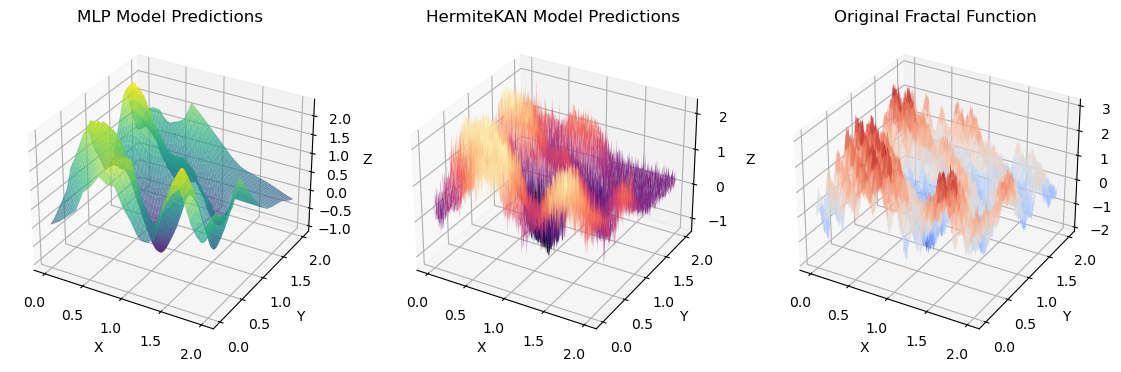

In [96]:
torch.autograd.set_detect_anomaly(True)

# Generate 2D sample data
x = np.linspace(0, 2, 100)
y = np.linspace(0, 2, 100)
X, Y = np.meshgrid(x, y)
Z = fractal_function(X, Y)
x_train_2d = torch.tensor(np.stack([X.ravel(), Y.ravel()], axis=1), dtype=torch.float32)
y_train_2d = torch.tensor(Z.ravel(), dtype=torch.float32).unsqueeze(1)

# Instantiate the models
mlp_model = SimpleMLP()  
hermite_model = HermiteKAN()

# Define loss functions and optimizers
criterion = nn.MSELoss()
optimizer_mlp = torch.optim.Adam(mlp_model.parameters(), lr=0.01)
optimizer_hermite = torch.optim.Adam(hermite_model.parameters(), lr=0.015)

# Train the models
epochs = 2000
for epoch in range(epochs):
    # MLP Training
    optimizer_mlp.zero_grad()
    outputs_mlp = mlp_model(x_train_2d)
    loss_mlp = criterion(outputs_mlp, y_train_2d)
    loss_mlp.backward()
    optimizer_mlp.step()

    # HermiteKAN Training
    optimizer_hermite.zero_grad()
    outputs_hermite = hermite_model(x_train_2d)
    loss_hermite = criterion(outputs_hermite, y_train_2d)
    loss_hermite.backward()
    optimizer_hermite.step()

    if epoch % 100 == 0:
        print(f'Epoch {epoch+1}/{epochs}, MLP Loss: {loss_mlp.item():.4f}, HermiteKAN Loss: {loss_hermite.item():.4f}')

# Test the models
x_test = np.linspace(0, 2, 400)
y_test = np.linspace(0, 2, 400)
X_test, Y_test = np.meshgrid(x_test, y_test)
Z_test = fractal_function(X_test, Y_test)
x_test_2d = torch.tensor(np.stack([X_test.ravel(), Y_test.ravel()], axis=1), dtype=torch.float32)
y_pred_mlp = mlp_model(x_test_2d).detach().numpy()
y_pred_hermite = hermite_model(x_test_2d).detach().numpy()

# Plot the results using a 3D plot
fig = plt.figure(figsize=(14, 21))
ax1 = fig.add_subplot(131, projection='3d')
ax1.plot_surface(X_test, Y_test, y_pred_mlp.reshape(X_test.shape), cmap='viridis', alpha=0.7, label='MLP Prediction')
ax1.set_title('MLP Model Predictions')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')

ax2 = fig.add_subplot(132, projection='3d')
ax2.plot_surface(X_test, Y_test, y_pred_hermite.reshape(X_test.shape), cmap='magma', alpha=0.7, label='HermiteKAN Prediction')
ax2.set_title('HermiteKAN Model Predictions')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')

ax3 = fig.add_subplot(133, projection='3d')
ax3.plot_surface(X_test, Y_test, Z_test, cmap='coolwarm', alpha=0.7, label='Original Function')
ax3.set_title('Original Fractal Function')
ax3.set_xlabel('X')
ax3.set_ylabel('Y')
ax3.set_zlabel('Z')
plt.show()